In [3]:
import torch
from torch import optim
from torch.utils.data import DataLoader
from data.data_preparer import DataPreparer
from src.predictor.multilayer_perceptron import MultiLayerPerceptronPredictor
from src.predictor.neural_network_trainer import NeuralNetworkTrainer
from src.data.data_reader import DataReader
import os
import pandas as pd
from tools.RestaurantReviewsDataset import RestaurantReviewsDataset

while str(os.getcwd())[-3:] != 'src':  # Execute from src-directory root
    os.chdir('..')

In [4]:
businesses, reviews, tips = DataReader().read_data()
user_profiles = pd.read_parquet("NLP/FIRST_USER_PROFILES.parquet")
train_test_data = DataPreparer.get_train_test_validate(businesses, reviews, tips, user_profiles)

model = MultiLayerPerceptronPredictor(input_size=train_test_data[0].columns.size, output_size=1)
optimizer = optim.Adam(model.parameters(), lr=0.002)

nn_trainer = NeuralNetworkTrainer(*train_test_data)
# model, optimizer = nn_trainer.train(model, optimizer, epochs=50 * 4, save_to_disk=True)
model.load(optimizer)

(MultiLayerPerceptronPredictor(
   (flatten): Flatten(start_dim=1, end_dim=-1)
   (linear_stack): Sequential(
     (0): Linear(in_features=150, out_features=75, bias=True)
     (1): Sigmoid()
     (2): Linear(in_features=75, out_features=37, bias=True)
     (3): ReLU()
     (4): Linear(in_features=37, out_features=18, bias=True)
     (5): Sigmoid()
     (6): Linear(in_features=18, out_features=9, bias=True)
     (7): Sigmoid()
     (8): Linear(in_features=9, out_features=1, bias=True)
   )
 ),
 Adam (
 Parameter Group 0
     amsgrad: False
     betas: (0.9, 0.999)
     capturable: False
     differentiable: False
     eps: 1e-08
     foreach: None
     fused: None
     lr: 0.002
     maximize: False
     weight_decay: 0
 ))

In [39]:
model.eval()  # Prepare layers of model for evaluation
import matplotlib.pyplot as plt

result = ""

with torch.no_grad():
    testX, testY = train_test_data[1], train_test_data[3]

    testX = testX.head(500)
    testY = testY.head(500)

    dl = RestaurantReviewsDataset(testX.to_numpy(), testY.to_numpy())
    test_loader = DataLoader(dl, batch_size=500)
    for x, y in test_loader:
        # Prepare data
        x, y = DataPreparer.get_tensor_for_ml(x, y)
        # Compute predictions and loss

        predictions = model(x)
        predictions = predictions.cpu().detach().numpy().squeeze().transpose()
        y = y.cpu().detach().numpy().squeeze().transpose()
        result = pd.DataFrame(data=[predictions, y]).transpose()
        result.columns = ['predicted', 'actual']
        #result['predicted'] = result['predicted'].transform(lambda x: round(x * 4 + 1))
        #result['actual'] = result['actual'].transform(lambda x: int(x * 4 + 1))
        result['difference'] =abs(result['predicted'] - result['actual'])
        print(sum(result['difference']))


result

100.61526657268405


,predicted,actual,difference
0,0.229630,0.25,0.020370
1,0.712303,1.00,0.287697
2,0.734373,0.75,0.015627
3,0.309933,0.75,0.440067
4,0.967031,0.75,0.217031
...,...,...,...
495,0.234370,0.75,0.515630
496,0.986426,0.75,0.236426
497,0.750992,0.25,0.500992
498,0.270655,0.25,0.020655


Histogram of differences between prediction and actual:


(array([213.,   0., 216.,   0.,   0.,  51.,   0.,  16.,   0.,   4.]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <BarContainer object of 10 artists>)

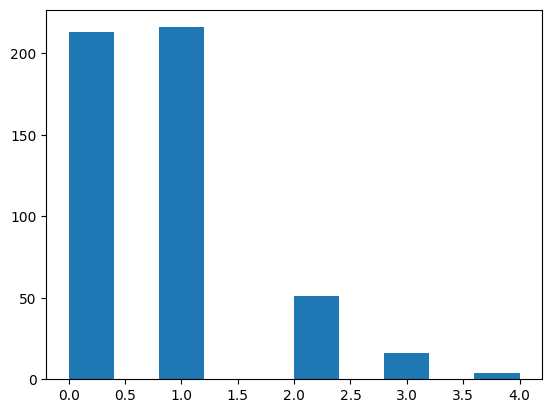

In [38]:
print("Histogram of differences between prediction and actual:")
plt.hist(result['difference'])